# Support Vector Machine Basics

## 1. Introduction

Support Vector Machines (SVMs) are powerful supervised learning algorithms used for classification and regression tasks. Introduced by Vapnik and colleagues in the 1990s, SVMs are particularly effective in high-dimensional spaces and remain one of the most robust classification methods in machine learning.

## 2. Mathematical Foundation

### 2.1 Linear Classification

Given a training dataset $\{(\mathbf{x}_i, y_i)\}_{i=1}^{n}$ where $\mathbf{x}_i \in \mathbb{R}^d$ and $y_i \in \{-1, +1\}$, a linear classifier seeks a hyperplane:

$$\mathbf{w}^T \mathbf{x} + b = 0$$

where $\mathbf{w} \in \mathbb{R}^d$ is the weight vector (normal to the hyperplane) and $b \in \mathbb{R}$ is the bias term.

### 2.2 Maximum Margin Principle

The key insight of SVM is to find the hyperplane that maximizes the **margin** - the distance between the hyperplane and the nearest training points (support vectors).

The distance from a point $\mathbf{x}_i$ to the hyperplane is:

$$\text{distance} = \frac{|\mathbf{w}^T \mathbf{x}_i + b|}{\|\mathbf{w}\|}$$

For correctly classified points, we require:

$$y_i(\mathbf{w}^T \mathbf{x}_i + b) \geq 1$$

The margin width is $\frac{2}{\|\mathbf{w}\|}$, so maximizing the margin is equivalent to minimizing $\|\mathbf{w}\|^2$.

### 2.3 Optimization Problem

The **primal formulation** for hard-margin SVM is:

$$\min_{\mathbf{w}, b} \frac{1}{2}\|\mathbf{w}\|^2$$

subject to: $y_i(\mathbf{w}^T \mathbf{x}_i + b) \geq 1, \quad \forall i = 1, \ldots, n$

### 2.4 Soft-Margin SVM

For non-separable data, we introduce **slack variables** $\xi_i \geq 0$:

$$\min_{\mathbf{w}, b, \xi} \frac{1}{2}\|\mathbf{w}\|^2 + C\sum_{i=1}^{n}\xi_i$$

subject to: $y_i(\mathbf{w}^T \mathbf{x}_i + b) \geq 1 - \xi_i$ and $\xi_i \geq 0$

The parameter $C > 0$ controls the trade-off between maximizing the margin and minimizing classification errors.

### 2.5 Dual Formulation and Lagrange Multipliers

Using Lagrange multipliers $\alpha_i \geq 0$, the dual problem becomes:

$$\max_{\alpha} \sum_{i=1}^{n} \alpha_i - \frac{1}{2}\sum_{i=1}^{n}\sum_{j=1}^{n} \alpha_i \alpha_j y_i y_j \mathbf{x}_i^T \mathbf{x}_j$$

subject to: $\sum_{i=1}^{n} \alpha_i y_i = 0$ and $0 \leq \alpha_i \leq C$

The solution yields:

$$\mathbf{w} = \sum_{i=1}^{n} \alpha_i y_i \mathbf{x}_i$$

Points with $\alpha_i > 0$ are the **support vectors**.

### 2.6 Kernel Trick

For non-linear classification, we map data to a higher-dimensional feature space via $\phi(\mathbf{x})$. The kernel function computes inner products in this space:

$$K(\mathbf{x}_i, \mathbf{x}_j) = \phi(\mathbf{x}_i)^T \phi(\mathbf{x}_j)$$

Common kernels include:

- **Linear:** $K(\mathbf{x}_i, \mathbf{x}_j) = \mathbf{x}_i^T \mathbf{x}_j$
- **Polynomial:** $K(\mathbf{x}_i, \mathbf{x}_j) = (\gamma \mathbf{x}_i^T \mathbf{x}_j + r)^d$
- **RBF (Gaussian):** $K(\mathbf{x}_i, \mathbf{x}_j) = \exp\left(-\gamma \|\mathbf{x}_i - \mathbf{x}_j\|^2\right)$

## 3. Implementation

We will implement SVM classification on synthetic datasets to demonstrate both linear and non-linear classification scenarios.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Set random seed for reproducibility
np.random.seed(42)

### 3.1 Generate Synthetic Data

We create a linearly separable dataset with two classes.

In [2]:
def generate_linear_data(n_samples=100, noise=0.1):
    """
    Generate linearly separable 2D data.
    
    Parameters:
    -----------
    n_samples : int
        Number of samples per class
    noise : float
        Standard deviation of Gaussian noise
    
    Returns:
    --------
    X : ndarray of shape (2*n_samples, 2)
        Feature matrix
    y : ndarray of shape (2*n_samples,)
        Labels (+1 or -1)
    """
    # Class +1: centered at (2, 2)
    X_pos = np.random.randn(n_samples, 2) * noise + np.array([2, 2])
    
    # Class -1: centered at (0, 0)
    X_neg = np.random.randn(n_samples, 2) * noise + np.array([0, 0])
    
    X = np.vstack([X_pos, X_neg])
    y = np.hstack([np.ones(n_samples), -np.ones(n_samples)])
    
    return X, y

# Generate training data
X_train, y_train = generate_linear_data(n_samples=50, noise=0.5)

print(f"Training data shape: X={X_train.shape}, y={y_train.shape}")
print(f"Class distribution: +1: {np.sum(y_train == 1)}, -1: {np.sum(y_train == -1)}")

Training data shape: X=(100, 2), y=(100,)
Class distribution: +1: 50, -1: 50


### 3.2 SVM Implementation Using Dual Formulation

We solve the dual optimization problem using sequential minimal optimization (SMO) principles.

In [3]:
class SVM:
    """
    Support Vector Machine classifier using the dual formulation.
    """
    
    def __init__(self, C=1.0, kernel='linear', gamma=1.0):
        """
        Initialize SVM classifier.
        
        Parameters:
        -----------
        C : float
            Regularization parameter
        kernel : str
            Kernel type: 'linear' or 'rbf'
        gamma : float
            Kernel coefficient for RBF
        """
        self.C = C
        self.kernel = kernel
        self.gamma = gamma
        self.alpha = None
        self.support_vectors = None
        self.support_vector_labels = None
        self.b = 0
        
    def _kernel_function(self, x1, x2):
        """Compute kernel between two vectors."""
        if self.kernel == 'linear':
            return np.dot(x1, x2)
        elif self.kernel == 'rbf':
            return np.exp(-self.gamma * np.sum((x1 - x2) ** 2))
        else:
            raise ValueError(f"Unknown kernel: {self.kernel}")
    
    def _compute_kernel_matrix(self, X):
        """Compute the kernel (Gram) matrix."""
        n = X.shape[0]
        K = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                K[i, j] = self._kernel_function(X[i], X[j])
        return K
    
    def fit(self, X, y):
        """
        Fit the SVM model.
        
        Parameters:
        -----------
        X : ndarray of shape (n_samples, n_features)
            Training data
        y : ndarray of shape (n_samples,)
            Target labels (+1 or -1)
        """
        n_samples = X.shape[0]
        
        # Compute kernel matrix
        K = self._compute_kernel_matrix(X)
        
        # Define the dual objective function (to minimize, so negate)
        def objective(alpha):
            return 0.5 * np.sum((alpha * y)[:, None] * (alpha * y)[None, :] * K) - np.sum(alpha)
        
        # Gradient of the objective
        def gradient(alpha):
            return (alpha * y)[:, None] * y[None, :] * K @ np.ones(n_samples) - np.ones(n_samples)
        
        # Constraints: sum(alpha_i * y_i) = 0
        constraints = {'type': 'eq', 'fun': lambda alpha: np.dot(alpha, y)}
        
        # Bounds: 0 <= alpha_i <= C
        bounds = [(0, self.C) for _ in range(n_samples)]
        
        # Initial guess
        alpha0 = np.zeros(n_samples)
        
        # Solve optimization problem
        result = minimize(objective, alpha0, method='SLSQP', 
                         bounds=bounds, constraints=constraints,
                         options={'maxiter': 1000, 'ftol': 1e-8})
        
        self.alpha = result.x
        
        # Identify support vectors (alpha > threshold)
        sv_threshold = 1e-5
        sv_indices = self.alpha > sv_threshold
        
        self.support_vectors = X[sv_indices]
        self.support_vector_labels = y[sv_indices]
        self.support_vector_alphas = self.alpha[sv_indices]
        
        # Compute bias term using support vectors on the margin
        # These are points where 0 < alpha < C
        margin_sv = (self.alpha > sv_threshold) & (self.alpha < self.C - sv_threshold)
        
        if np.sum(margin_sv) > 0:
            self.b = np.mean(
                y[margin_sv] - np.sum(
                    (self.alpha * y)[:, None] * K[:, margin_sv], axis=0
                )
            )
        else:
            # Fallback: use all support vectors
            self.b = np.mean(
                self.support_vector_labels - np.array([
                    np.sum(self.support_vector_alphas * self.support_vector_labels * 
                           np.array([self._kernel_function(sv, x) 
                                    for sv in self.support_vectors]))
                    for x in self.support_vectors
                ])
            )
        
        # Store training data for predictions
        self.X_train = X
        self.y_train = y
        
        return self
    
    def decision_function(self, X):
        """
        Compute the decision function for samples.
        
        Parameters:
        -----------
        X : ndarray of shape (n_samples, n_features)
            Input samples
            
        Returns:
        --------
        decision : ndarray of shape (n_samples,)
            Decision function values
        """
        decision = np.zeros(X.shape[0])
        for i, x in enumerate(X):
            s = 0
            for alpha, y_sv, sv in zip(self.support_vector_alphas, 
                                       self.support_vector_labels,
                                       self.support_vectors):
                s += alpha * y_sv * self._kernel_function(sv, x)
            decision[i] = s + self.b
        return decision
    
    def predict(self, X):
        """
        Predict class labels.
        
        Parameters:
        -----------
        X : ndarray of shape (n_samples, n_features)
            Input samples
            
        Returns:
        --------
        y_pred : ndarray of shape (n_samples,)
            Predicted labels
        """
        return np.sign(self.decision_function(X))

### 3.3 Train Linear SVM

In [4]:
# Create and train linear SVM
svm_linear = SVM(C=10.0, kernel='linear')
svm_linear.fit(X_train, y_train)

# Print results
print(f"Number of support vectors: {len(svm_linear.support_vectors)}")
print(f"Bias term (b): {svm_linear.b:.4f}")

# Compute training accuracy
y_pred = svm_linear.predict(X_train)
accuracy = np.mean(y_pred == y_train)
print(f"Training accuracy: {accuracy * 100:.2f}%")

Number of support vectors: 3
Bias term (b): -2.7425
Training accuracy: 100.00%


### 3.4 Visualization Functions

In [5]:
def plot_decision_boundary(svm, X, y, ax, title):
    """
    Plot the decision boundary and margins of an SVM.
    
    Parameters:
    -----------
    svm : SVM
        Trained SVM classifier
    X : ndarray
        Feature matrix
    y : ndarray
        Labels
    ax : matplotlib axes
        Axes to plot on
    title : str
        Plot title
    """
    # Create mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    # Compute decision function on grid
    Z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary and margins
    ax.contourf(xx, yy, Z, levels=50, cmap='RdBu', alpha=0.3)
    ax.contour(xx, yy, Z, levels=[-1, 0, 1], colors=['blue', 'black', 'red'],
               linestyles=['--', '-', '--'], linewidths=[1.5, 2, 1.5])
    
    # Plot data points
    ax.scatter(X[y == 1, 0], X[y == 1, 1], c='red', marker='o', 
               edgecolors='k', s=50, label='Class +1')
    ax.scatter(X[y == -1, 0], X[y == -1, 1], c='blue', marker='s',
               edgecolors='k', s=50, label='Class -1')
    
    # Highlight support vectors
    ax.scatter(svm.support_vectors[:, 0], svm.support_vectors[:, 1],
               s=200, facecolors='none', edgecolors='green', linewidths=2,
               label='Support Vectors')
    
    ax.set_xlabel('$x_1$', fontsize=12)
    ax.set_ylabel('$x_2$', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.legend(loc='upper left', fontsize=9)

### 3.5 Non-Linear Classification with RBF Kernel

We now create a non-linearly separable dataset and apply the RBF kernel.

In [6]:
def generate_circular_data(n_samples=100, noise=0.1):
    """
    Generate circular (non-linearly separable) 2D data.
    
    Parameters:
    -----------
    n_samples : int
        Number of samples per class
    noise : float
        Standard deviation of Gaussian noise
    
    Returns:
    --------
    X : ndarray
        Feature matrix
    y : ndarray
        Labels
    """
    # Inner circle (class -1)
    r_inner = 1
    theta_inner = np.random.uniform(0, 2 * np.pi, n_samples)
    X_inner = np.column_stack([
        r_inner * np.cos(theta_inner) + np.random.randn(n_samples) * noise,
        r_inner * np.sin(theta_inner) + np.random.randn(n_samples) * noise
    ])
    
    # Outer circle (class +1)
    r_outer = 3
    theta_outer = np.random.uniform(0, 2 * np.pi, n_samples)
    X_outer = np.column_stack([
        r_outer * np.cos(theta_outer) + np.random.randn(n_samples) * noise,
        r_outer * np.sin(theta_outer) + np.random.randn(n_samples) * noise
    ])
    
    X = np.vstack([X_inner, X_outer])
    y = np.hstack([-np.ones(n_samples), np.ones(n_samples)])
    
    return X, y

# Generate circular data
X_circular, y_circular = generate_circular_data(n_samples=50, noise=0.2)

print(f"Circular data shape: X={X_circular.shape}, y={y_circular.shape}")

Circular data shape: X=(100, 2), y=(100,)


In [7]:
# Train RBF SVM
svm_rbf = SVM(C=10.0, kernel='rbf', gamma=0.5)
svm_rbf.fit(X_circular, y_circular)

print(f"Number of support vectors: {len(svm_rbf.support_vectors)}")

# Compute training accuracy
y_pred_rbf = svm_rbf.predict(X_circular)
accuracy_rbf = np.mean(y_pred_rbf == y_circular)
print(f"Training accuracy: {accuracy_rbf * 100:.2f}%")

Number of support vectors: 20
Training accuracy: 100.00%


### 3.6 Effect of Regularization Parameter C

We examine how different values of $C$ affect the decision boundary.

In [8]:
# Train SVMs with different C values
C_values = [0.1, 1.0, 100.0]
svm_models = []

for C in C_values:
    svm = SVM(C=C, kernel='linear')
    svm.fit(X_train, y_train)
    svm_models.append(svm)
    print(f"C={C}: {len(svm.support_vectors)} support vectors, "
          f"accuracy={np.mean(svm.predict(X_train) == y_train)*100:.1f}%")

C=0.1: 18 support vectors, accuracy=100.0%


C=1.0: 5 support vectors, accuracy=100.0%


C=100.0: 3 support vectors, accuracy=100.0%


## 4. Results Visualization

We create a comprehensive figure showing:
1. Linear SVM on separable data
2. RBF SVM on circular data
3. Effect of regularization parameter C

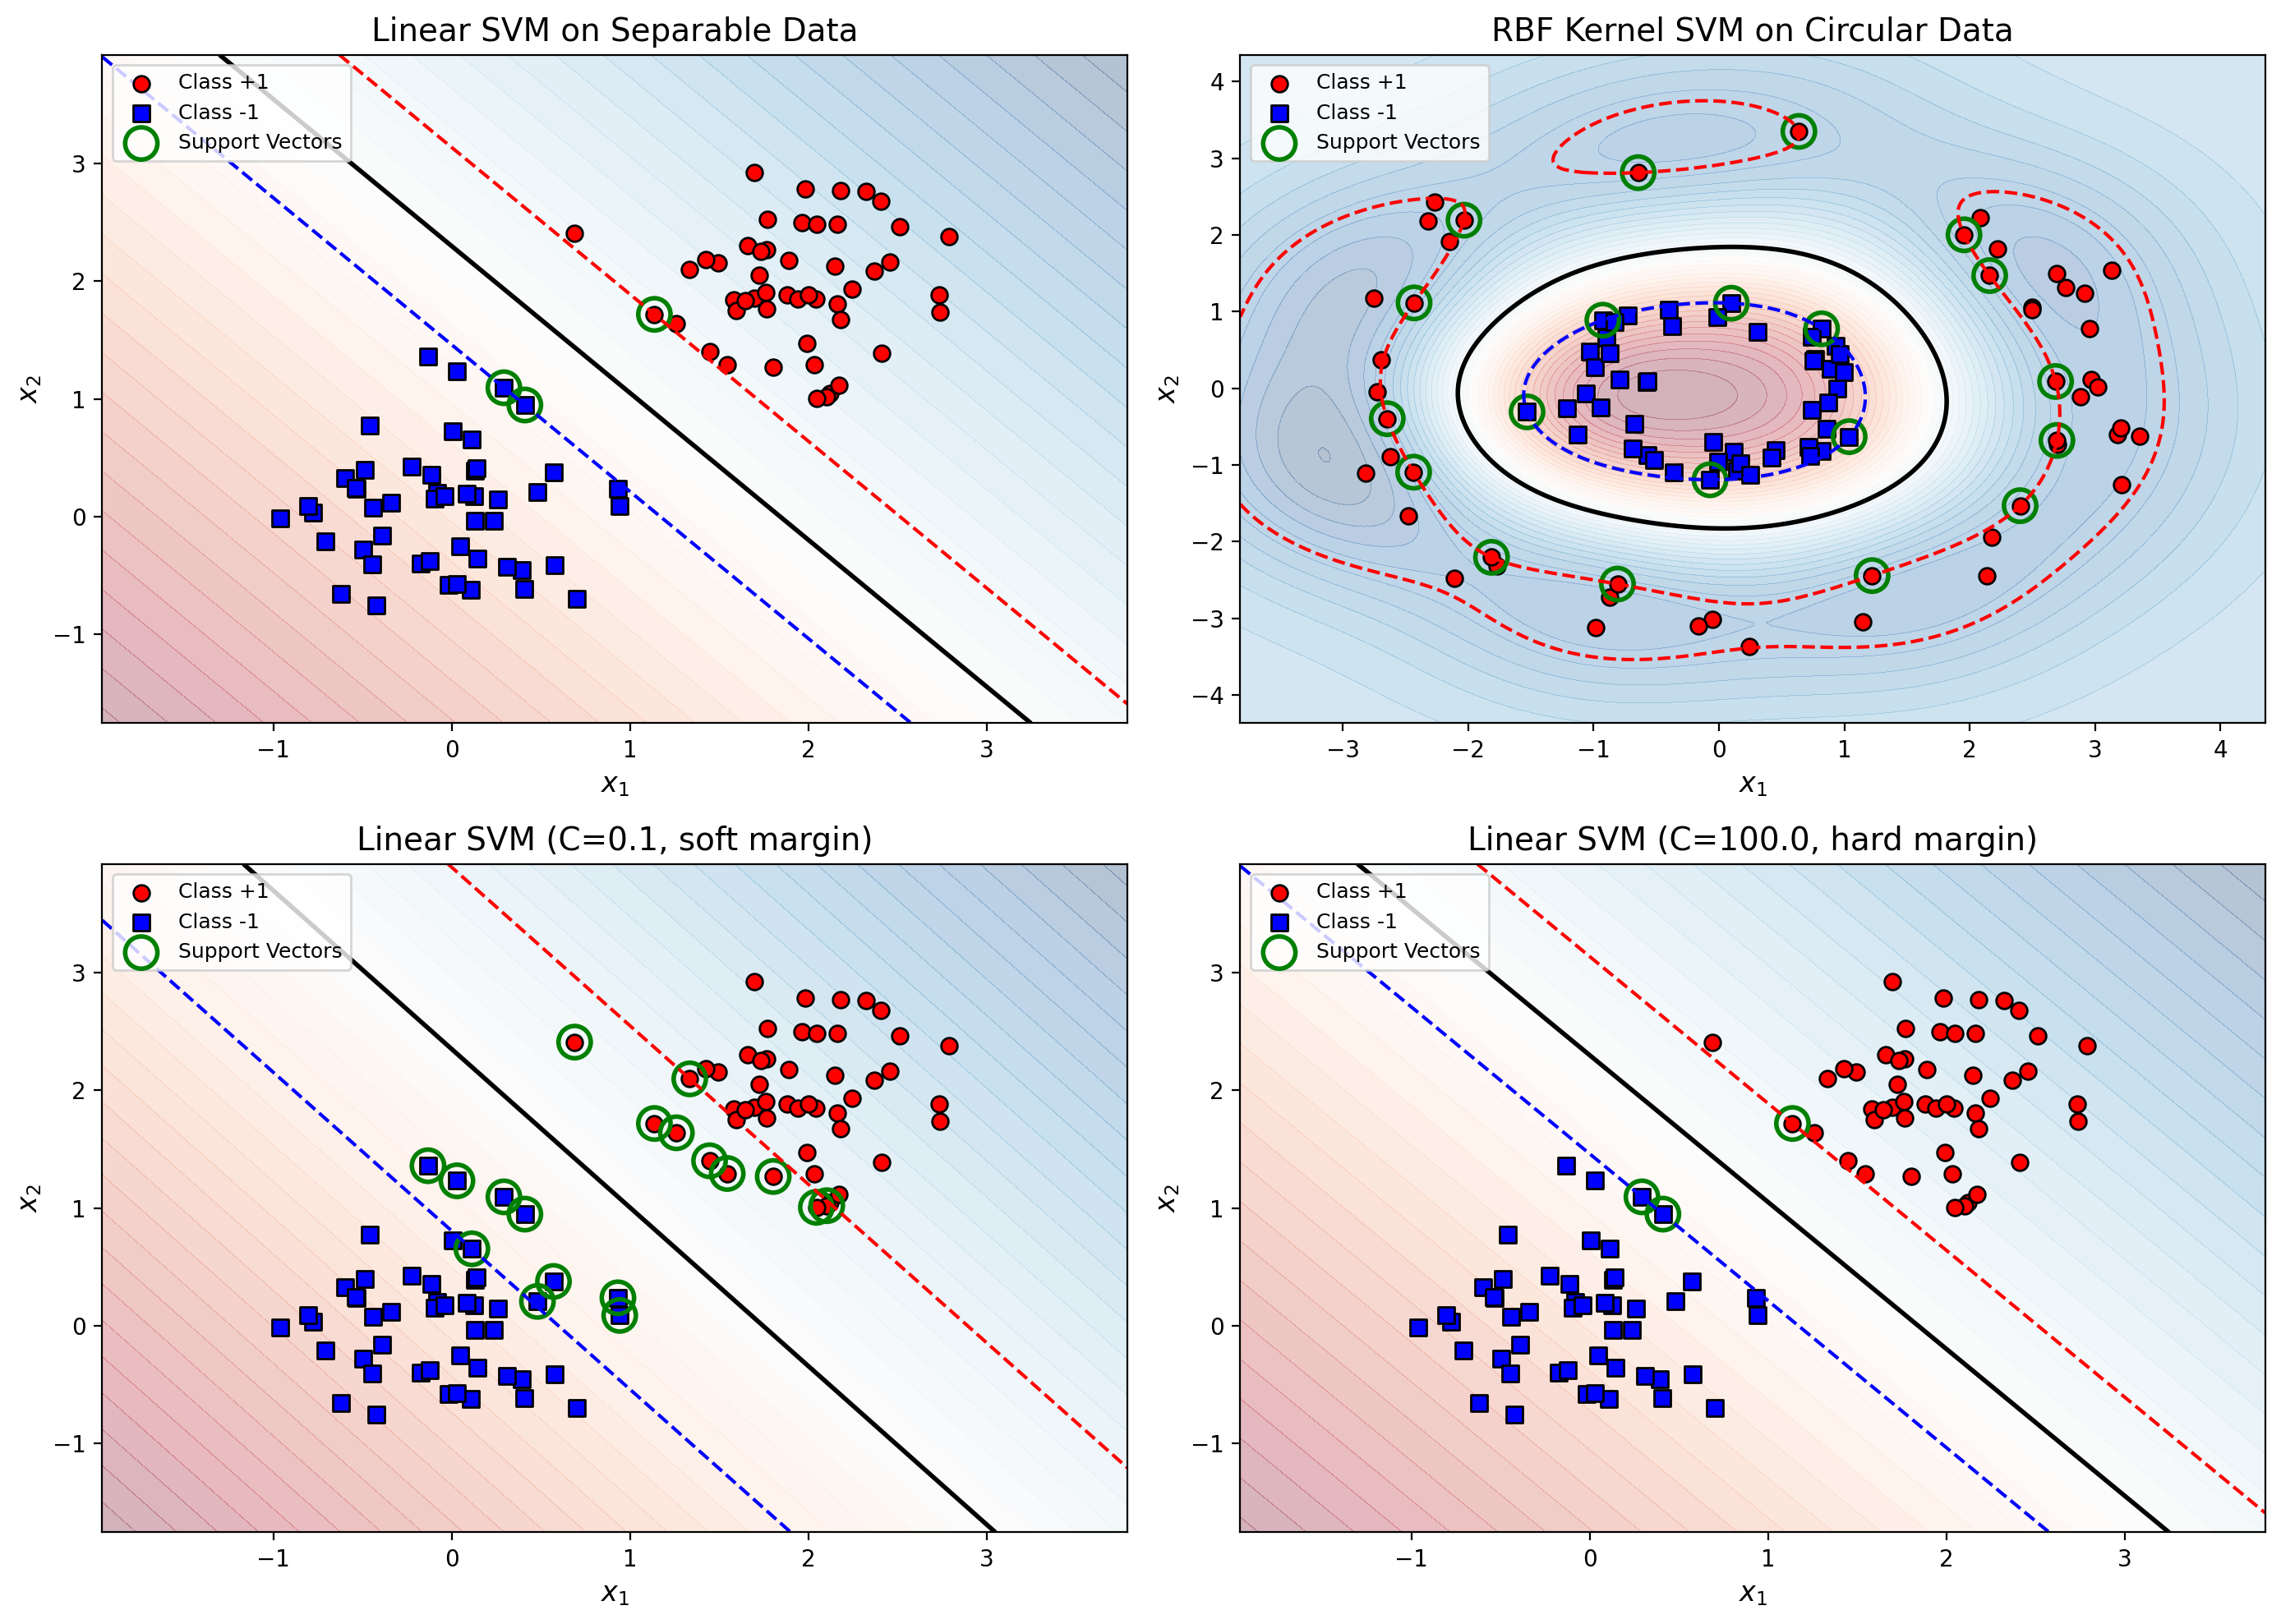


Figure saved to 'plot.png'


In [9]:
# Create comprehensive visualization
fig = plt.figure(figsize=(14, 10))

# Plot 1: Linear SVM
ax1 = fig.add_subplot(2, 2, 1)
plot_decision_boundary(svm_linear, X_train, y_train, ax1, 
                       'Linear SVM on Separable Data')

# Plot 2: RBF SVM
ax2 = fig.add_subplot(2, 2, 2)
plot_decision_boundary(svm_rbf, X_circular, y_circular, ax2,
                       'RBF Kernel SVM on Circular Data')

# Plot 3-4: Effect of C
ax3 = fig.add_subplot(2, 2, 3)
plot_decision_boundary(svm_models[0], X_train, y_train, ax3,
                       f'Linear SVM (C={C_values[0]}, soft margin)')

ax4 = fig.add_subplot(2, 2, 4)
plot_decision_boundary(svm_models[2], X_train, y_train, ax4,
                       f'Linear SVM (C={C_values[2]}, hard margin)')

plt.tight_layout()

# Save the figure
plt.savefig('support_vector_machine_basics_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved to 'plot.png'")

## 5. Summary

This notebook demonstrated the fundamental concepts of Support Vector Machines:

1. **Maximum Margin Principle**: SVMs find the optimal hyperplane by maximizing the margin between classes.

2. **Soft-Margin Classification**: The parameter $C$ controls the trade-off between margin width and classification errors, enabling SVMs to handle non-separable data.

3. **Kernel Trick**: By using kernel functions like RBF, SVMs can learn non-linear decision boundaries without explicitly computing high-dimensional feature mappings.

4. **Support Vectors**: Only a subset of training points (those on or within the margin) determine the decision boundary, making SVMs memory-efficient.

### Key Observations:

- Low $C$ values produce wider margins with more margin violations (soft margin)
- High $C$ values produce narrower margins with fewer violations (approaching hard margin)
- The RBF kernel can capture complex, non-linear decision boundaries
- The number of support vectors indicates model complexity

### References

1. Cortes, C., & Vapnik, V. (1995). Support-vector networks. *Machine Learning*, 20(3), 273-297.
2. Schölkopf, B., & Smola, A. J. (2002). *Learning with Kernels*. MIT Press.
3. Bishop, C. M. (2006). *Pattern Recognition and Machine Learning*. Springer.